# Importamos las librerias

In [1]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode

## Las direcciones del dataset

In [6]:
# Load directories
train_data_dir = "./dataset/training/image_2/"
train_gt_dir = "./dataset/training/gt_image_2/"

test_data_dir = "./dataset/testing/"

## Dividir el conjunto entre train, test and validation

In [7]:
# Number of training examples # 80 %
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

# Number of validations examples # 10 %

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

# Number of testing examples # 10 %

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


## Inicializamos constantes

In [8]:
IMG_SIZE = 128
N_CHANNELS = 3 # RGB
N_CLASSES = 1
SEED = 123 # Random Seed

In [9]:
# Function to load image and return a dictionary
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path) # load image
    image = tf.image.decode_jpeg(image, channels=3) # get image from jpeg format
    image = tf.image.convert_image_dtype(image, tf.uint8) # range between 0 to 250

    # Three types of img paths: um, umm, uu
    # gt image paths: um_road, umm_road, uu_road
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)

    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])

    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask}

## Generamos las variables del dataset

In [10]:
# Generate dataset variables
all_dataset = tf.data.Dataset.list_files(train_data_dir + "*.png", seed=SEED)
all_dataset = all_dataset.map(parse_image)

train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE)
val_dataset = train_dataset.skip(TRAINSET_SIZE)
train_dataset = train_dataset.take(TRAINSET_SIZE)
test_dataset = all_dataset.skip(TRAINSET_SIZE + VALIDSET_SIZE)

## Aplicamos transformaciones

In [11]:
# Tensorflow function to rescale images to [0, 1]
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

# Tensorflow function to apply preprocessing transformations
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Tensorflow function to preprocess validation images
@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [12]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])
print(dataset['test'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


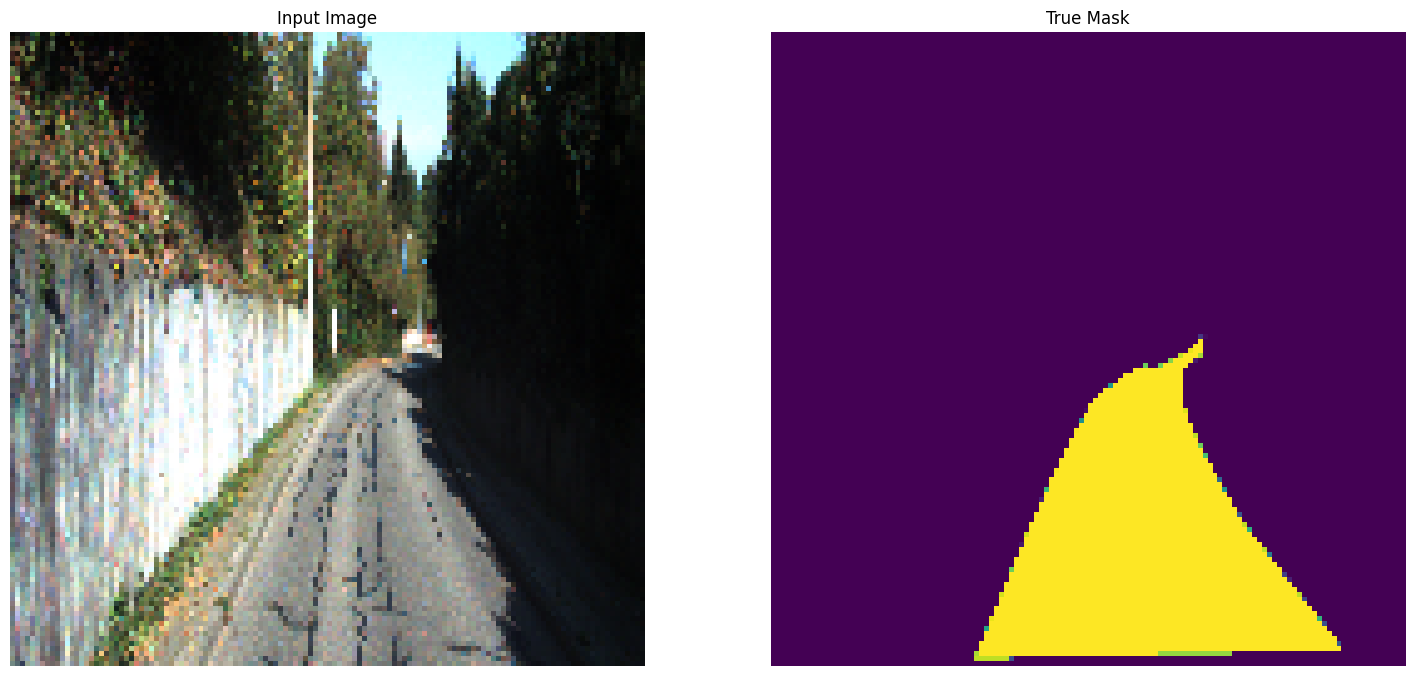

In [13]:
# Function to view the images from the directory
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for image, mask in dataset["train"].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

## Definir red

In [10]:
# Get VGG-16 network as backbone
vgg16_model = VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Define input shape
input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [12]:
# Generate a new model using the VGG network
# Input
inputs = Input(input_shape)

# VGG network
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = inputs)

# Encoder Layers
c1 = vgg16_model.get_layer("block3_pool").output         
c2 = vgg16_model.get_layer("block4_pool").output         
c3 = vgg16_model.get_layer("block5_pool").output         

# Decoder
u1 = UpSampling2D((2, 2), interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2, 2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, c1])

# Output
u3 = UpSampling2D((8, 8), interpolation = 'bilinear')(d2)
outputs = Conv2D(N_CLASSES, 1, activation = 'sigmoid')(u3)

model = Model(inputs, outputs, name = "VGG_FCN8")

## Training

In [13]:
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=[m_iou])

## Predicciones

1/1 [==============================] - 2s 2s/step


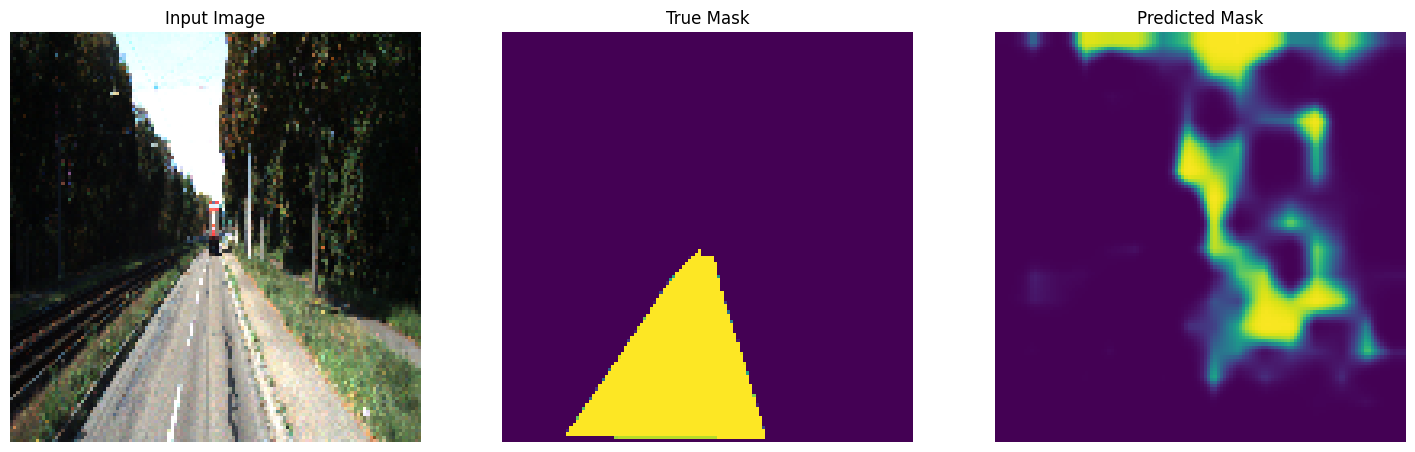

In [14]:
# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)
    
    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0],
                        inference[0]])
        
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

## Entrenamos el modelo

In [15]:
# Callbacks and Logs
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True)
]
        
# Set Variables
EPOCHS = 200
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALIDSET_SIZE // BATCH_SIZE

1/1 [==============================] - 2s 2s/step


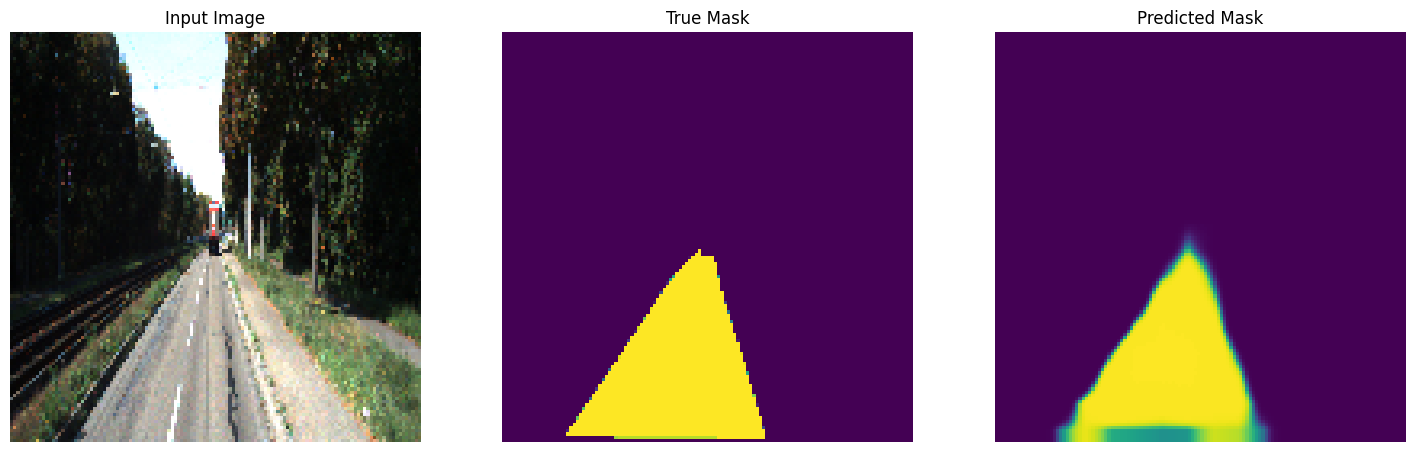


Sample Prediction after epoch 200

7/7 [==============================] - 71s 10s/step - loss: 0.0348 - mean_io_u: 0.4283


In [16]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = dataset["val"],
                          validation_steps=VALIDATION_STEPS,
                          callbacks = callbacks)

## Guardar modelo

In [21]:
model.save('cnn/model.h5', save_format='h5')

## Cargamos el modelo

In [2]:
modelT = keras.models.load_model("cnn/model.h5")

## Testing del modelo

In [3]:
# Function to calculate mask over image
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)
    
    # Convert to image image
    image = np.asarray(image, np.float32)
    
    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [4]:
# Function to save predictions
def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = modelT.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.savefig(f"outputs/{index}.png")
    plt.show()

Processing image : 0
1/1 [==============================] - 0s 248ms/step


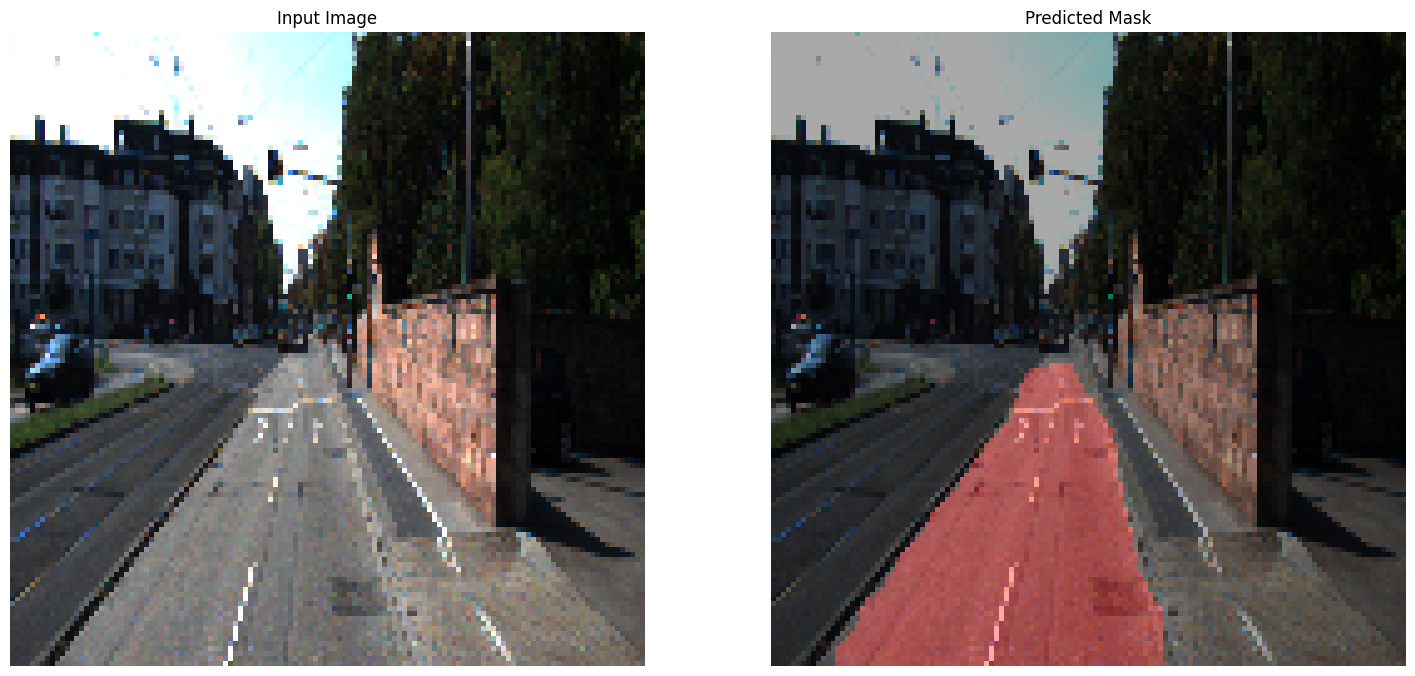

Processing image : 1
1/1 [==============================] - 0s 79ms/step


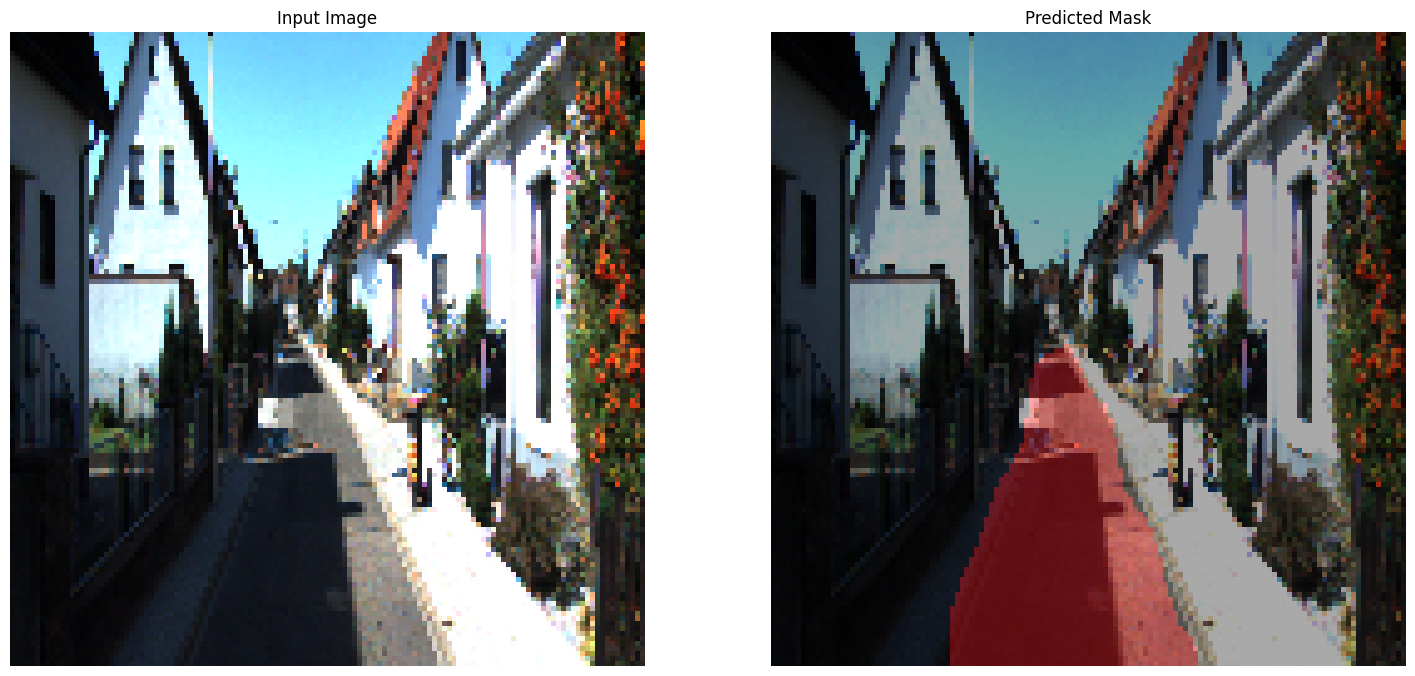

Processing image : 2
1/1 [==============================] - 0s 91ms/step


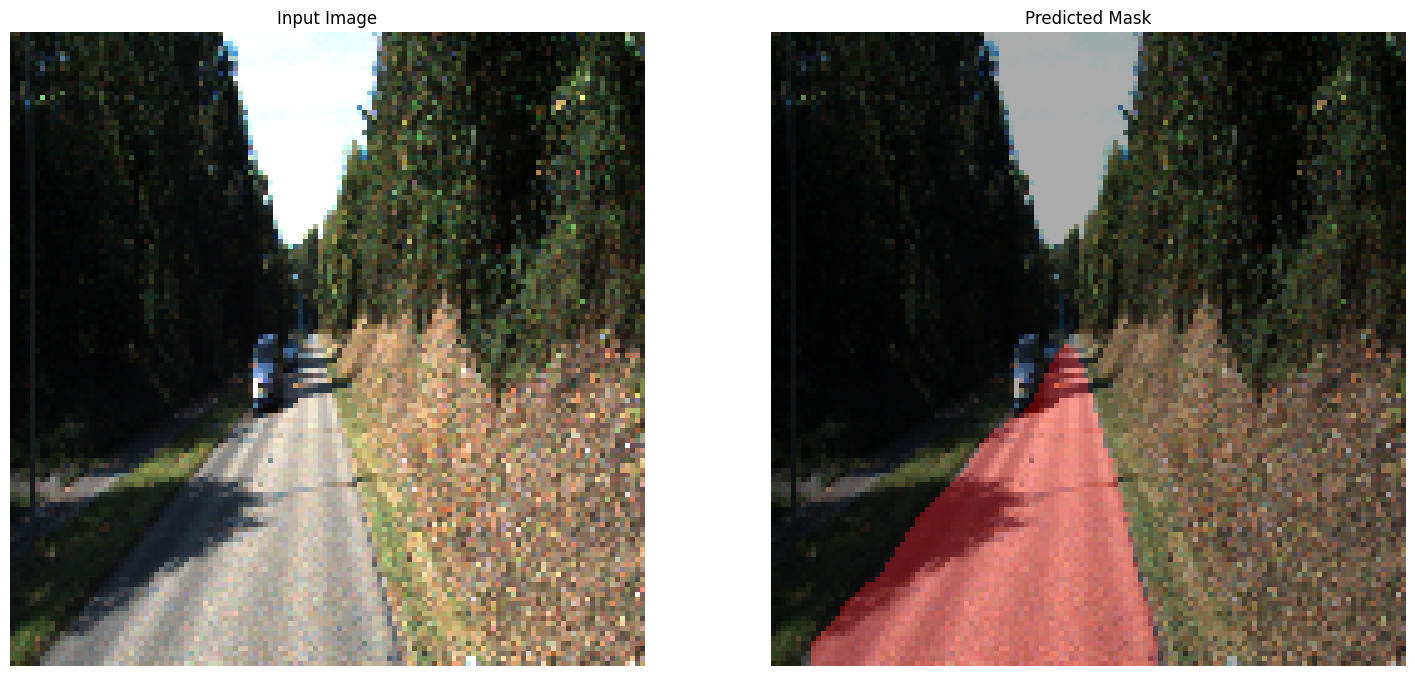

Processing image : 3
1/1 [==============================] - 0s 81ms/step


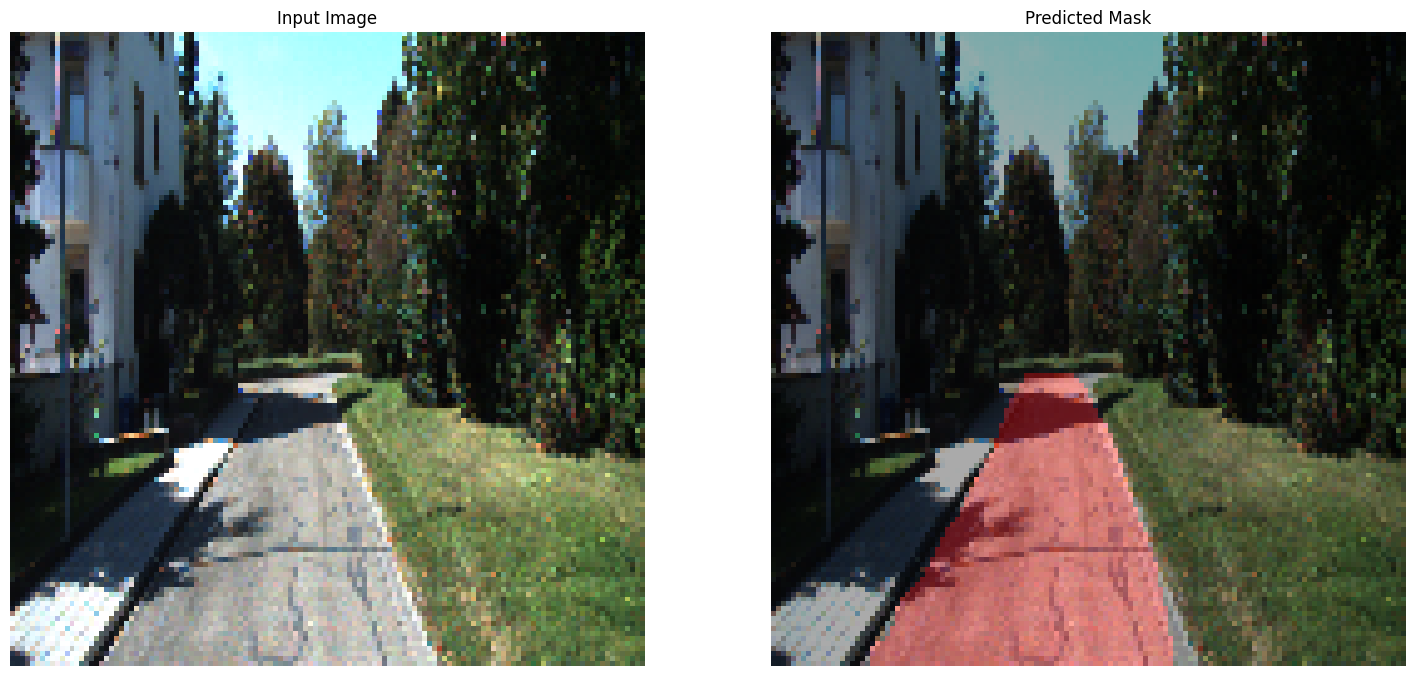

Processing image : 4
1/1 [==============================] - 0s 80ms/step


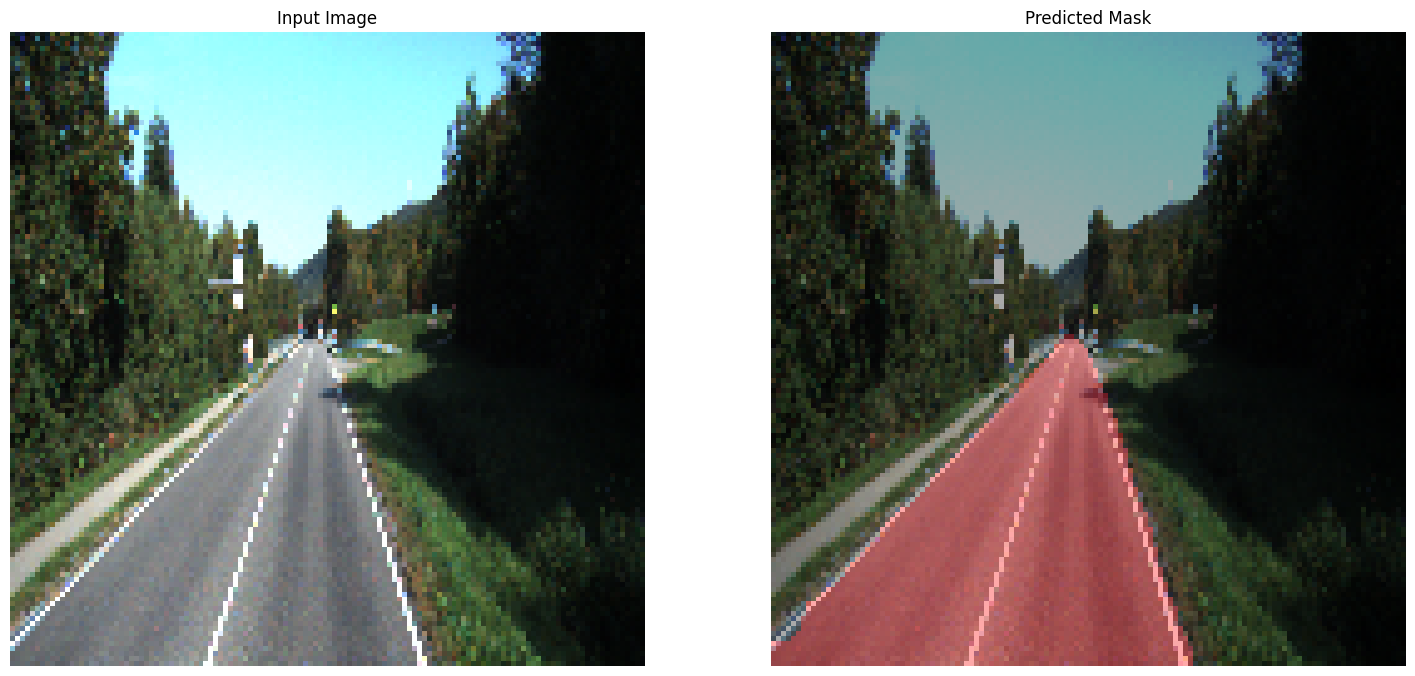

Processing image : 5
1/1 [==============================] - 0s 79ms/step


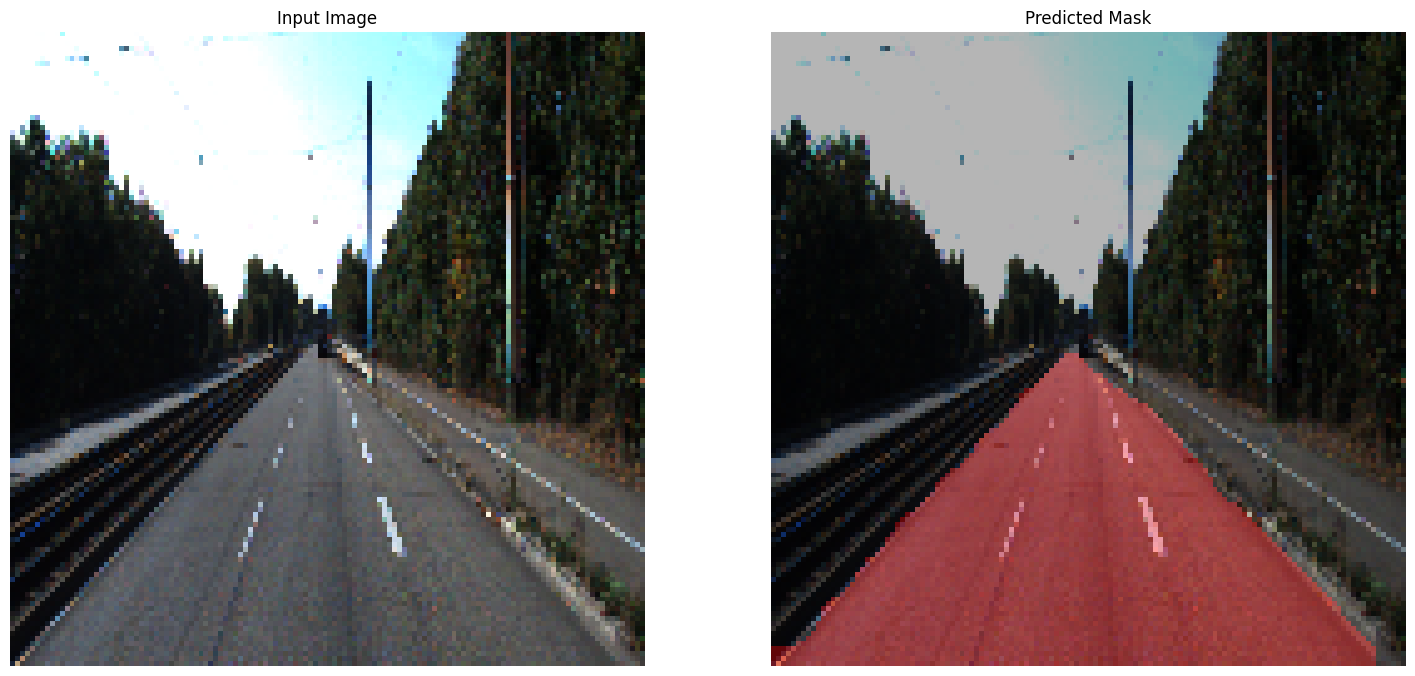

Processing image : 6
1/1 [==============================] - 0s 81ms/step


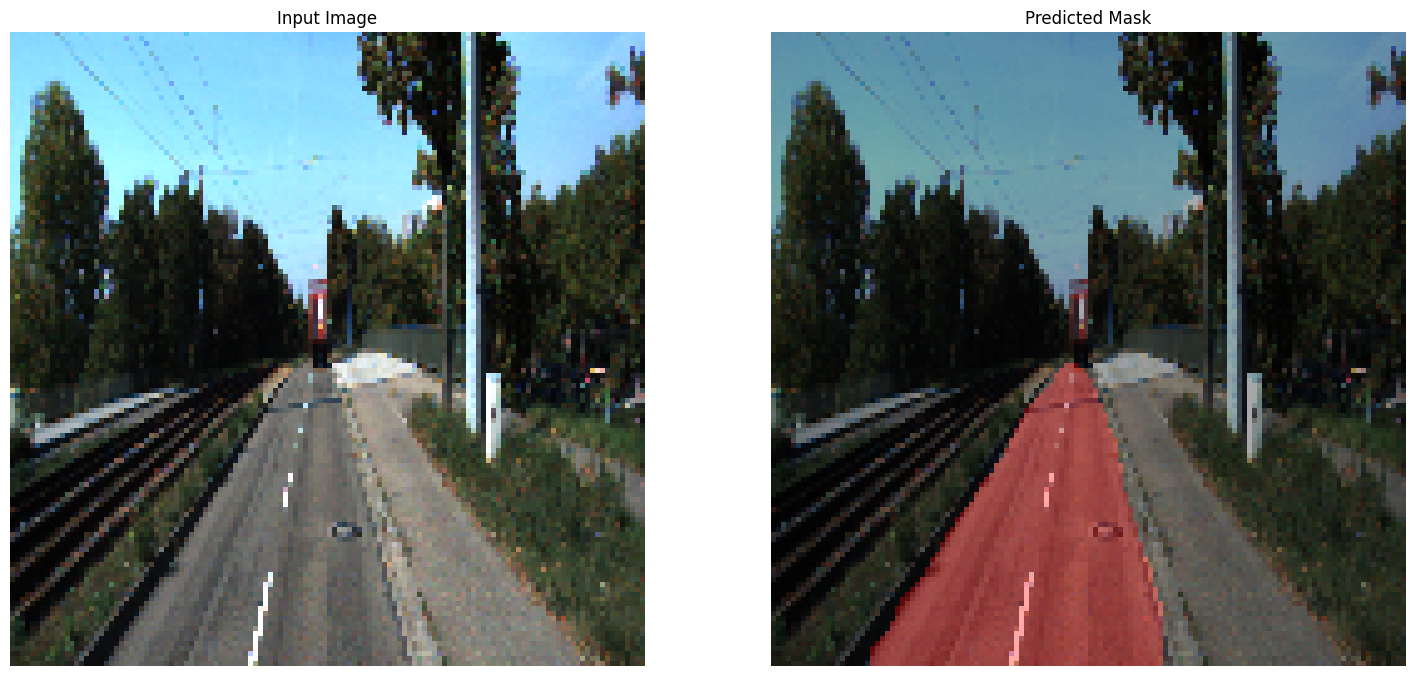

Processing image : 7
1/1 [==============================] - 0s 97ms/step


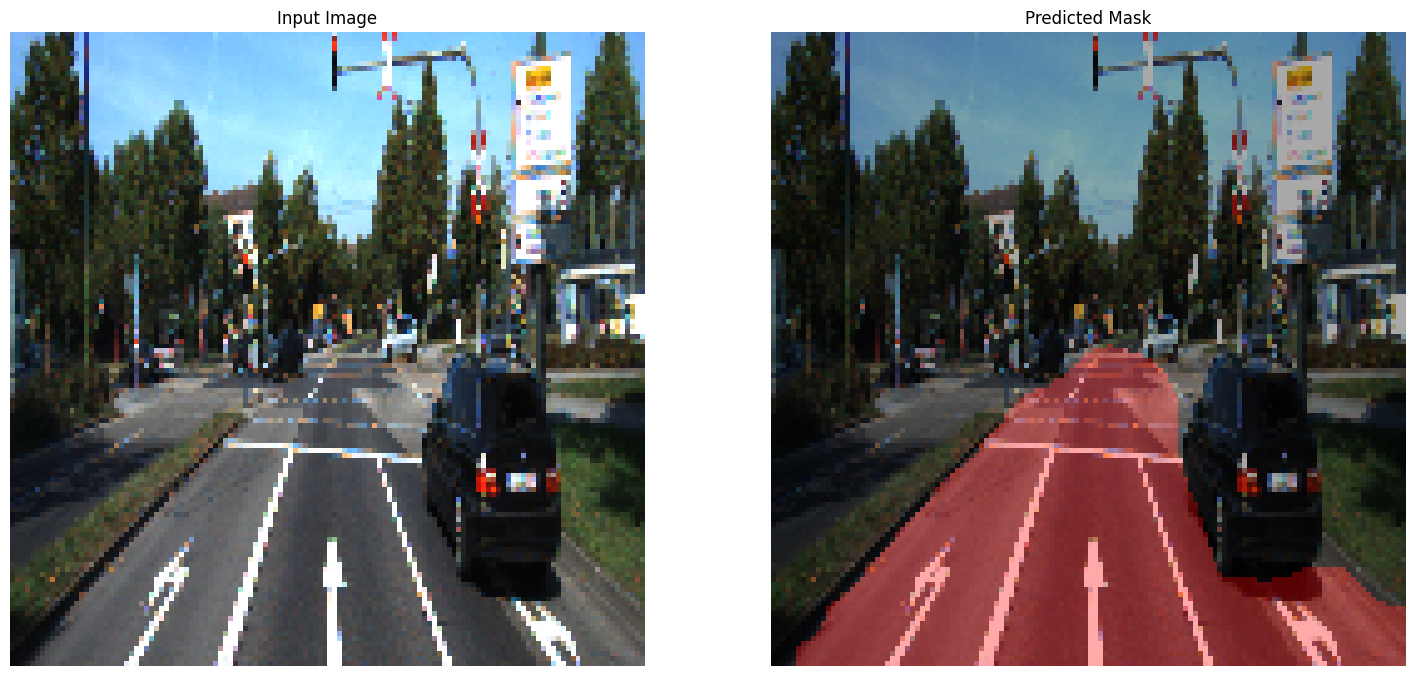

Processing image : 8
1/1 [==============================] - 0s 76ms/step


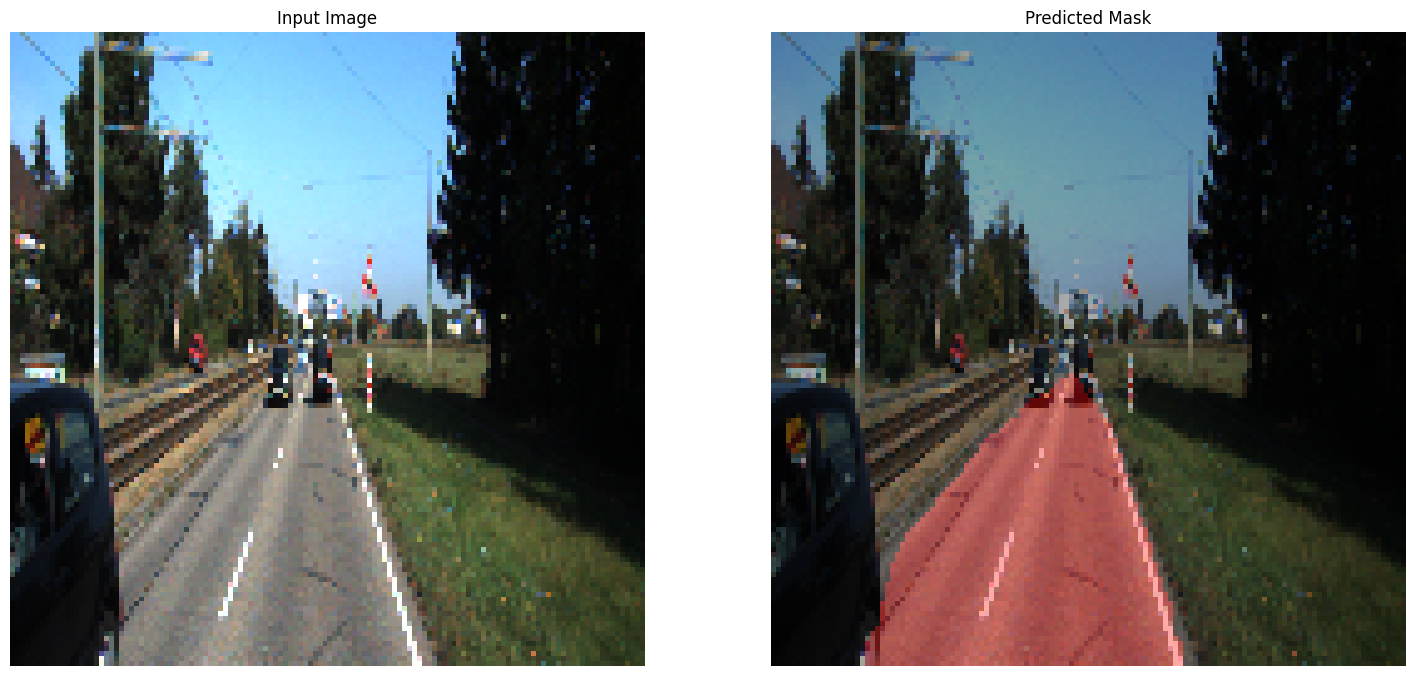

Processing image : 9
1/1 [==============================] - 0s 80ms/step


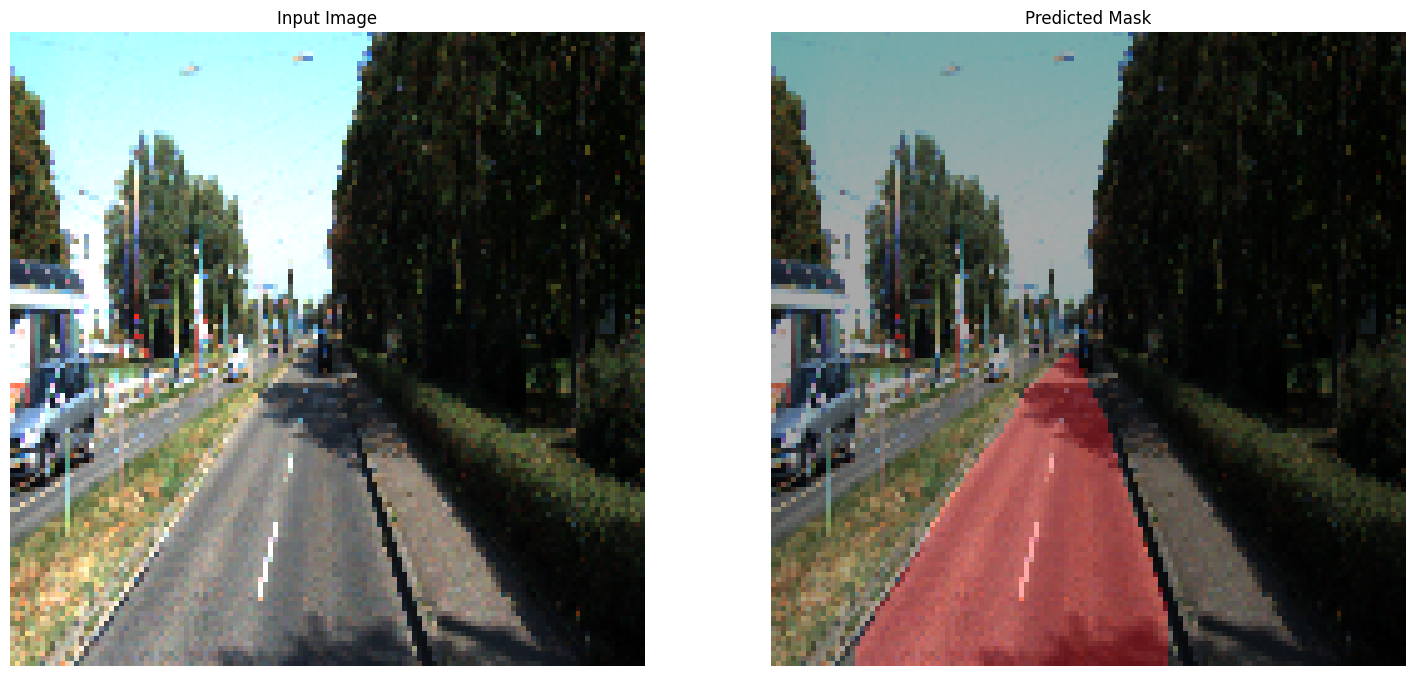

Processing image : 10
1/1 [==============================] - 0s 86ms/step


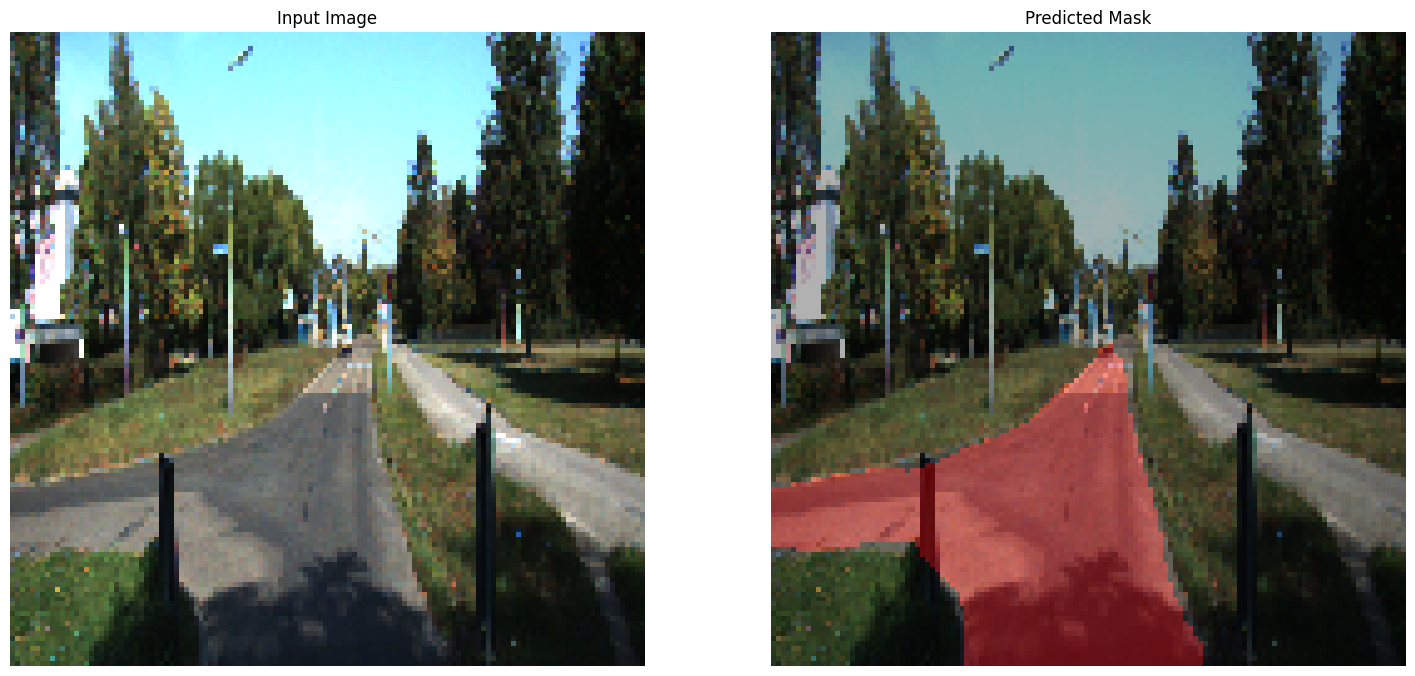

Processing image : 11
1/1 [==============================] - 0s 80ms/step


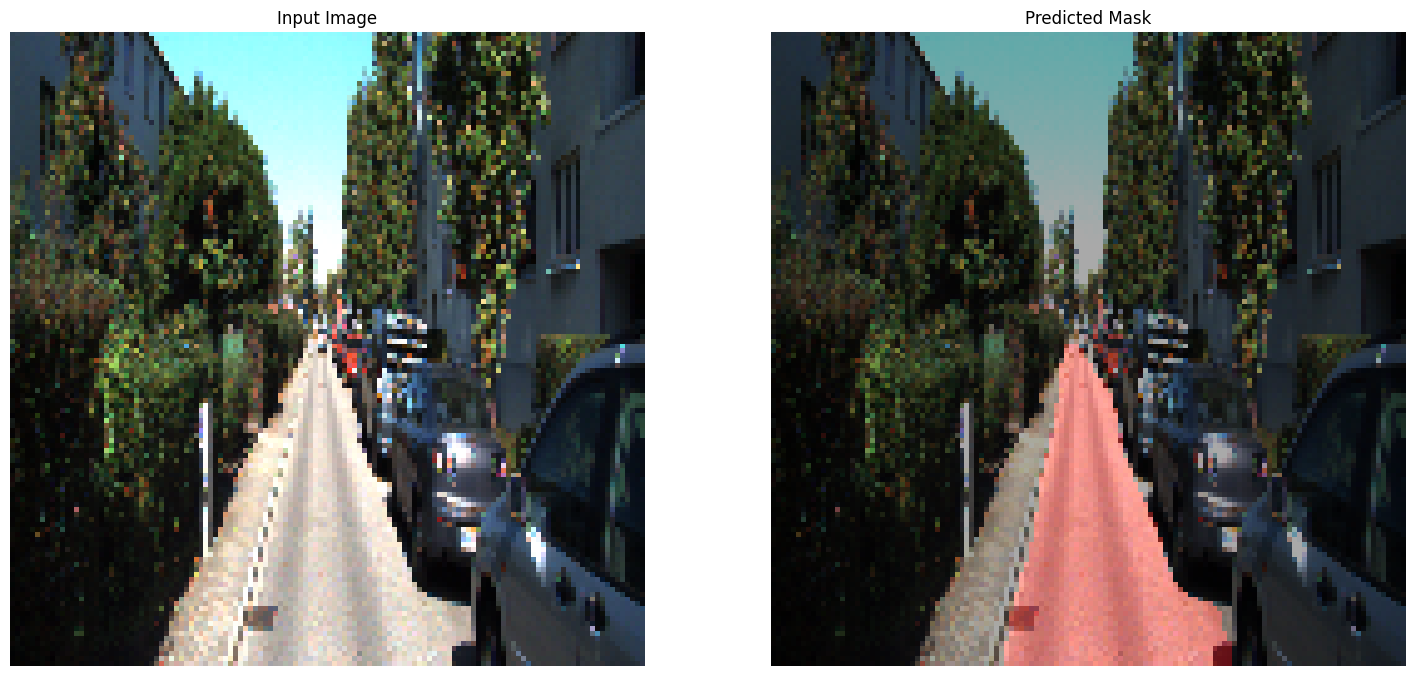

Processing image : 12
1/1 [==============================] - 0s 81ms/step


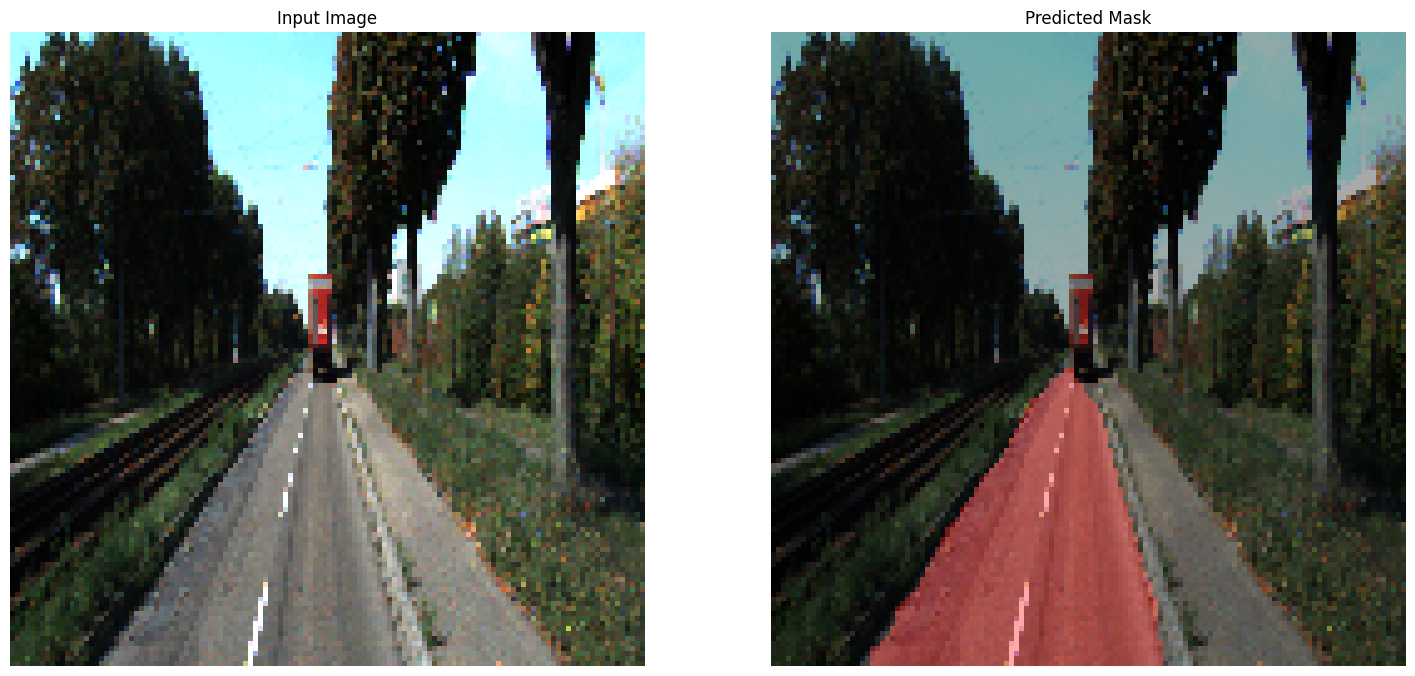

Processing image : 13
1/1 [==============================] - 0s 82ms/step


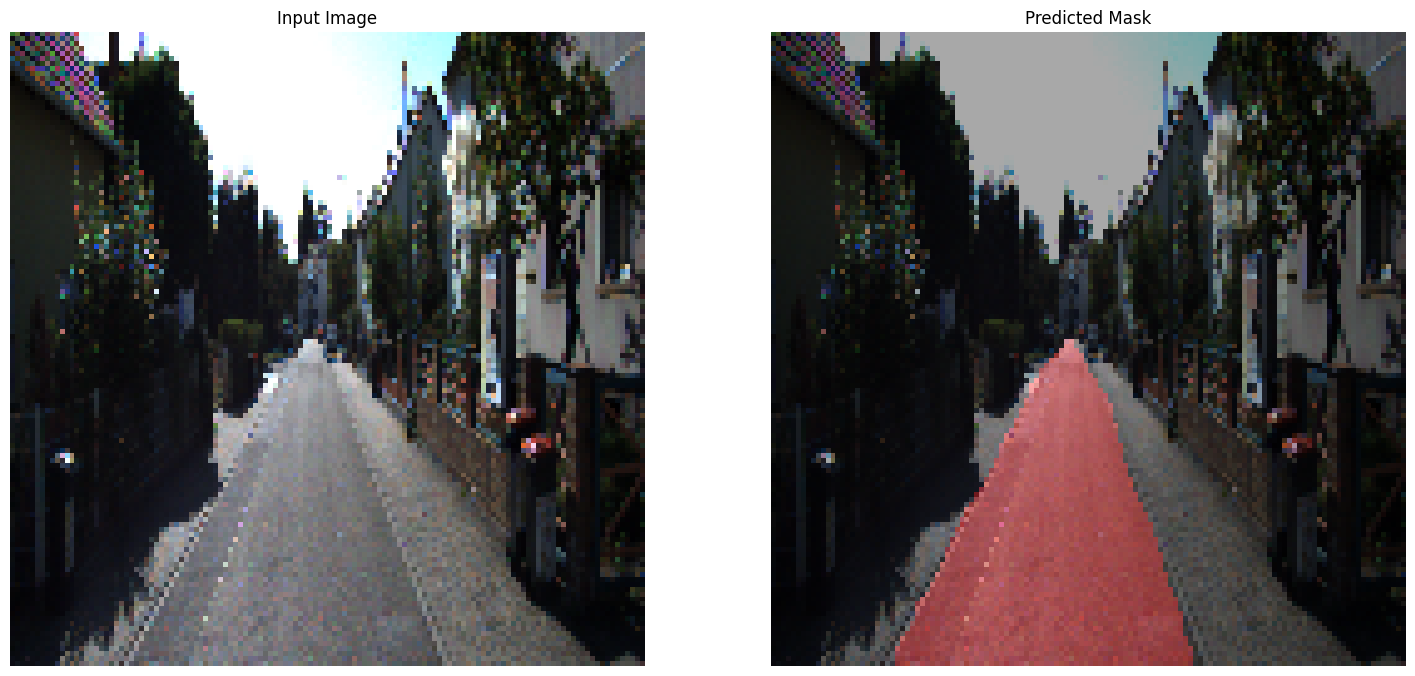

Processing image : 14
1/1 [==============================] - 0s 85ms/step


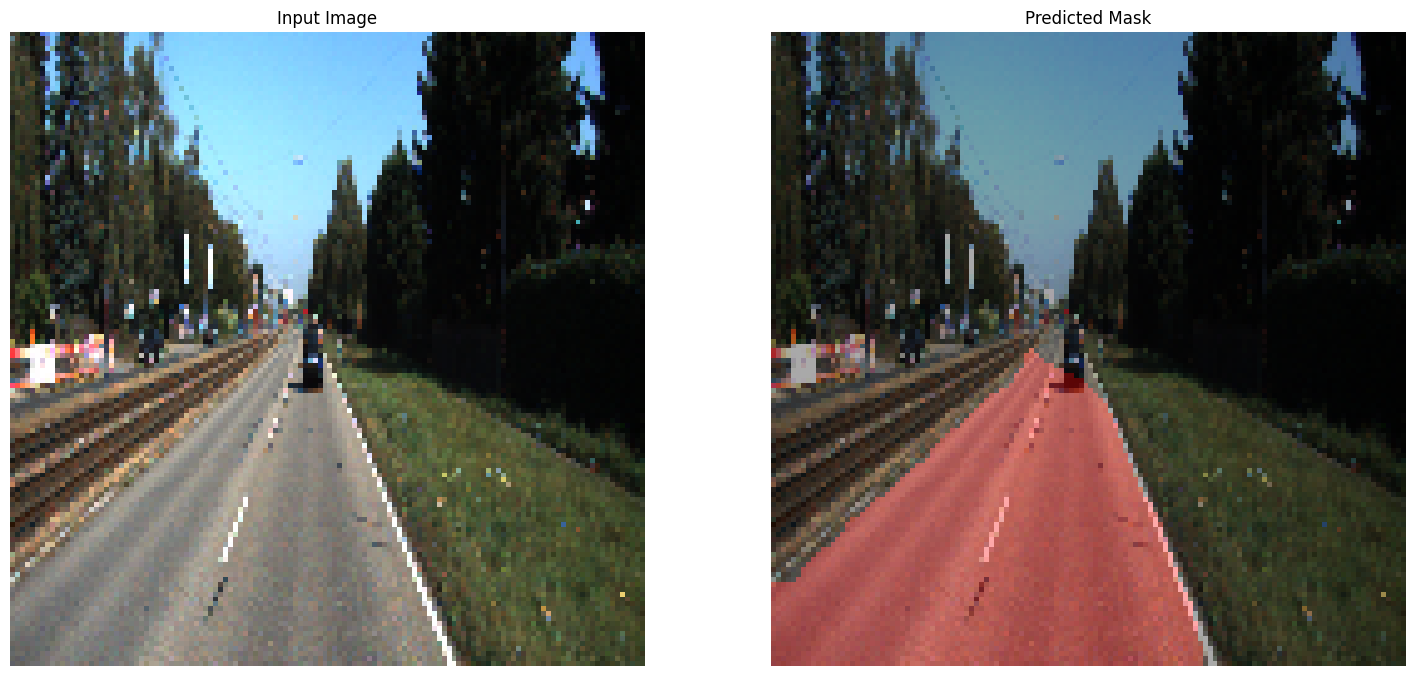

Processing image : 15
1/1 [==============================] - 0s 83ms/step


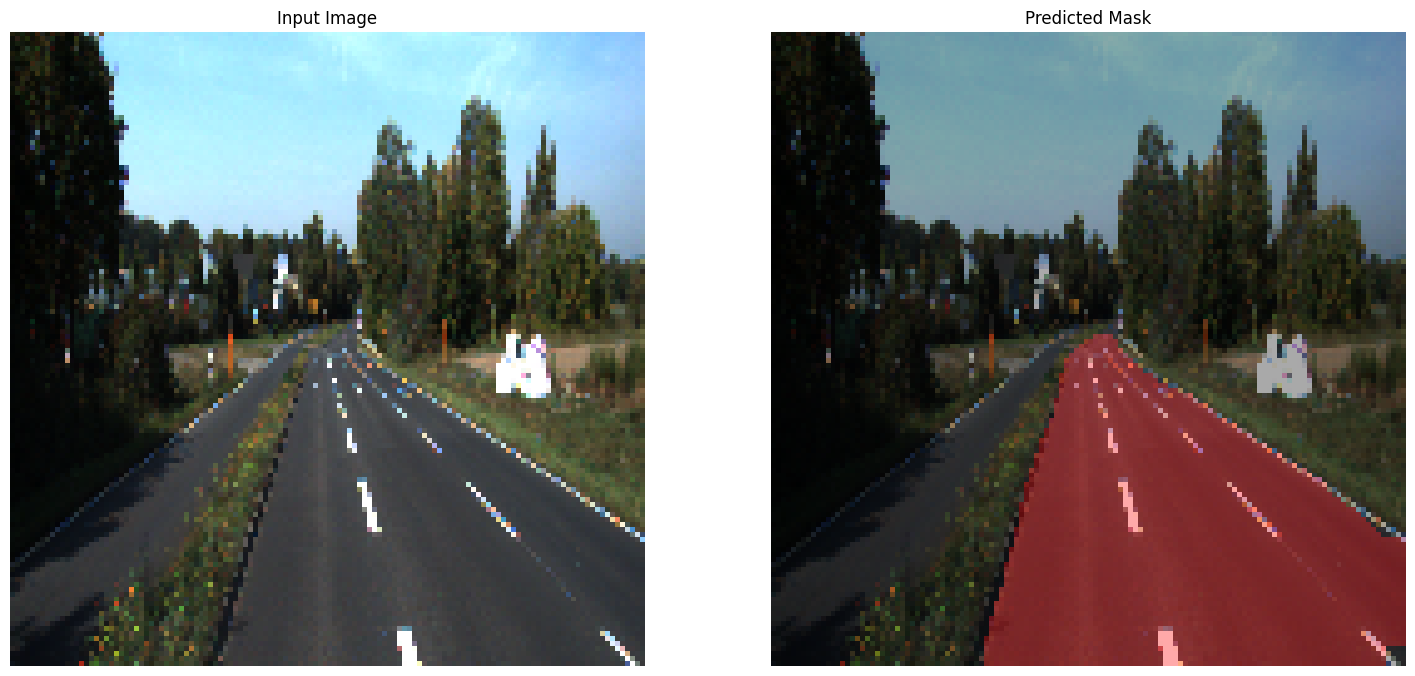

Processing image : 16
1/1 [==============================] - 0s 84ms/step


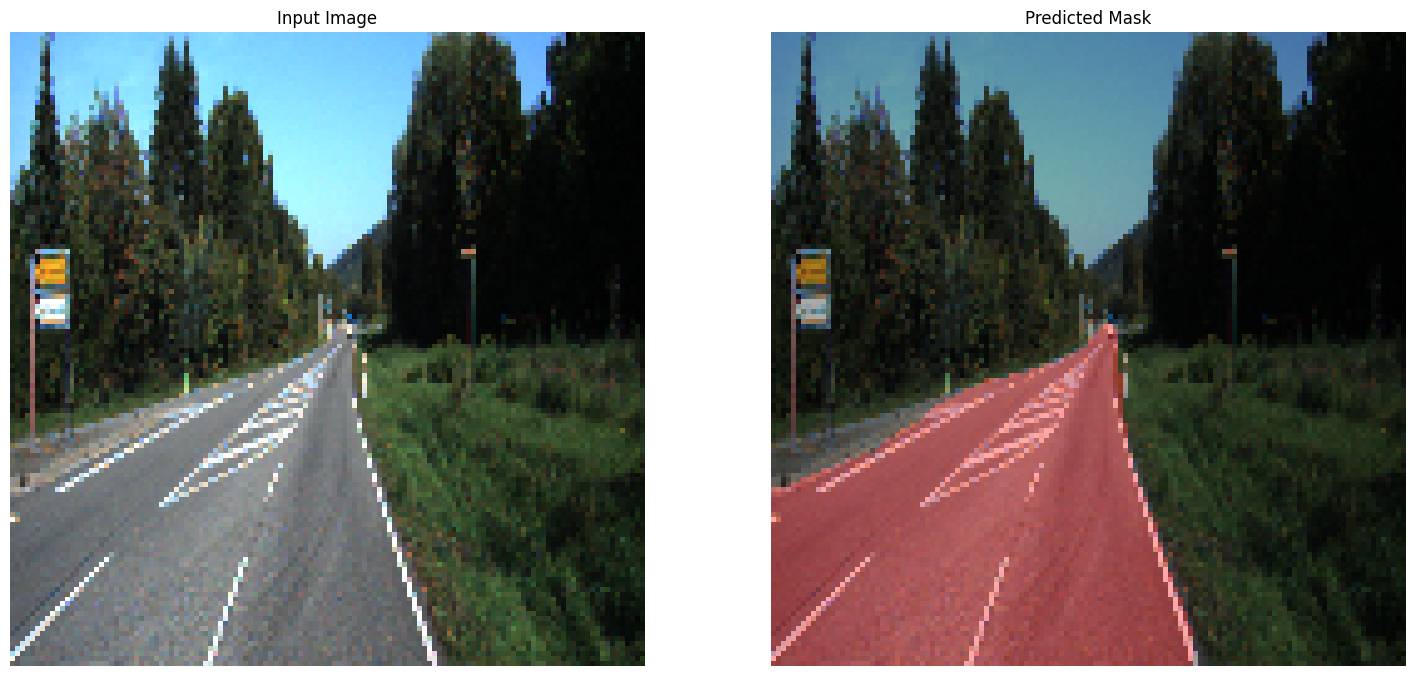

Processing image : 17
1/1 [==============================] - 0s 79ms/step


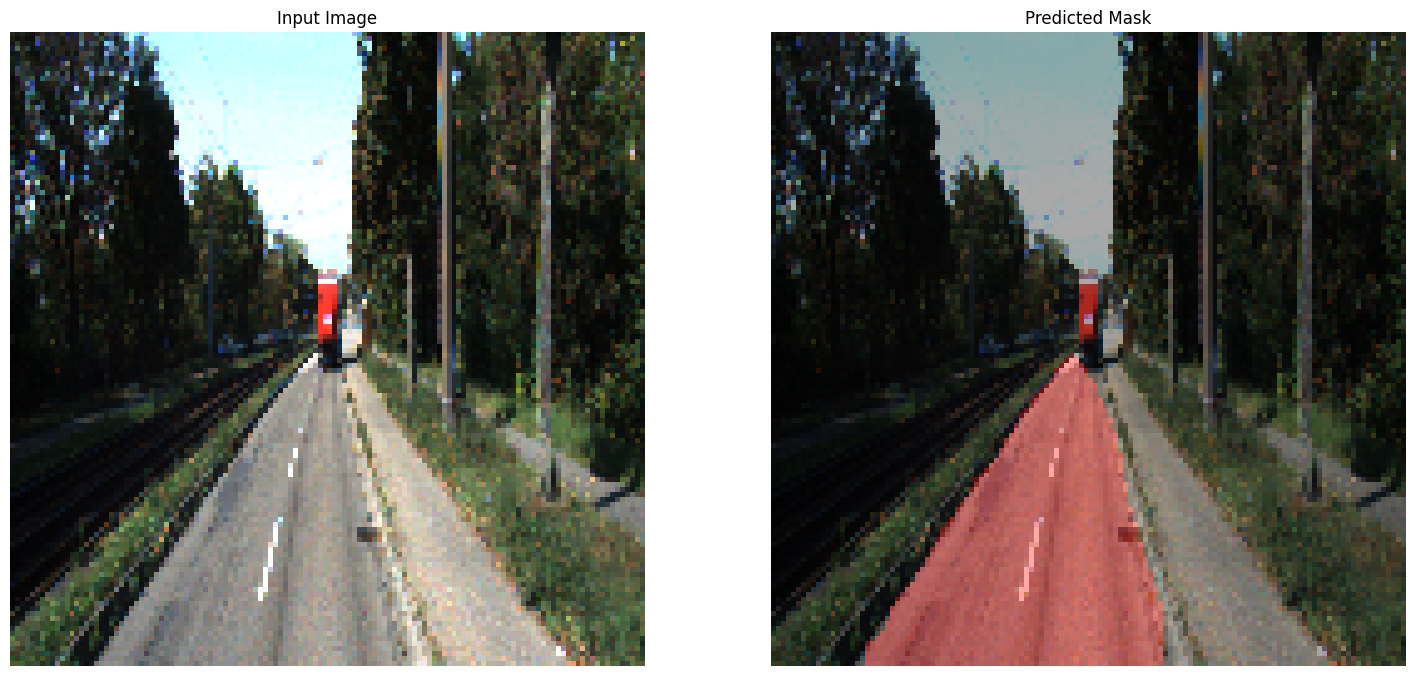

Processing image : 18
1/1 [==============================] - 0s 96ms/step


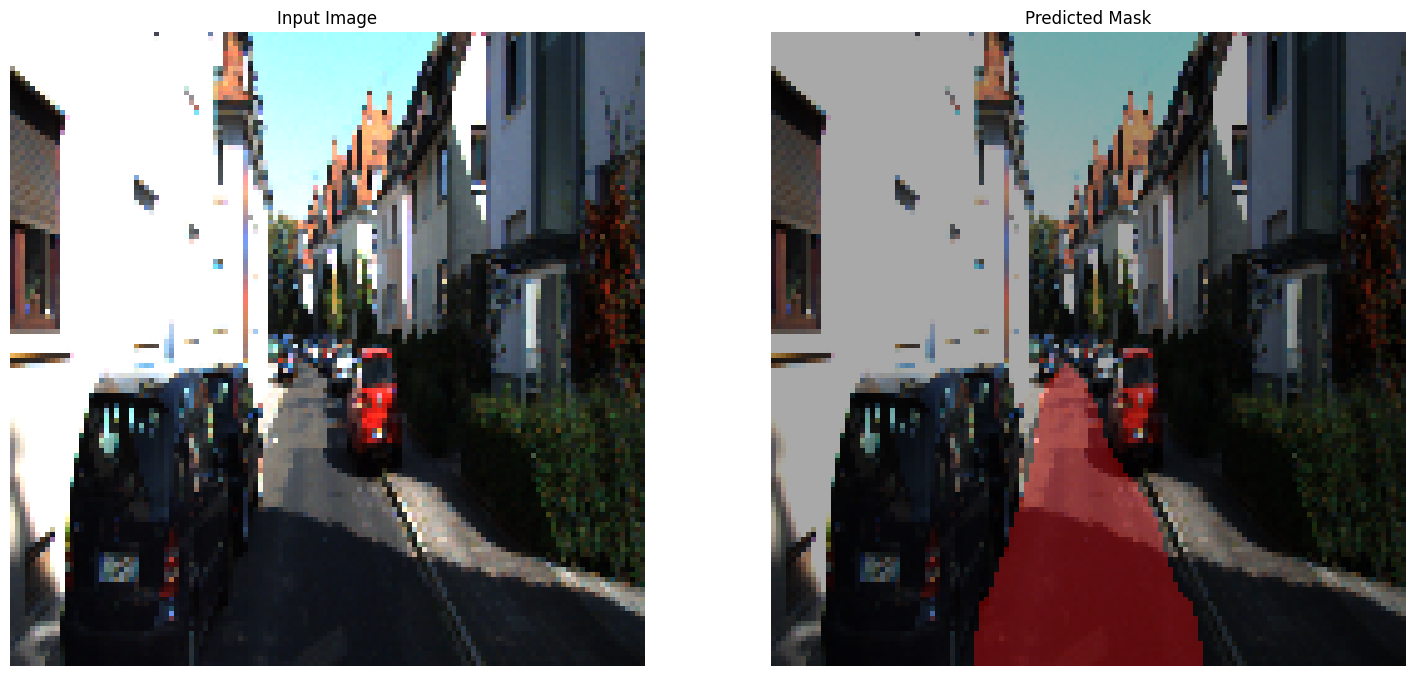

Processing image : 19
1/1 [==============================] - 0s 83ms/step


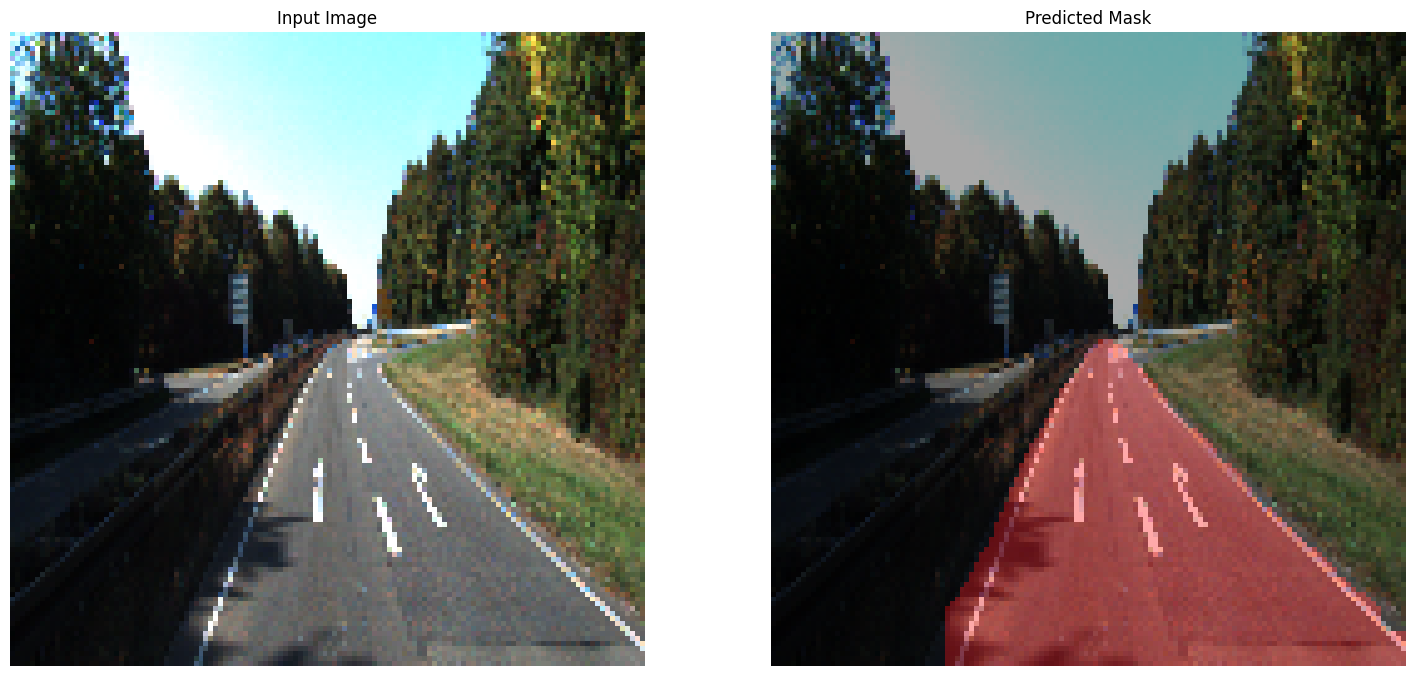

Processing image : 20
1/1 [==============================] - 0s 96ms/step


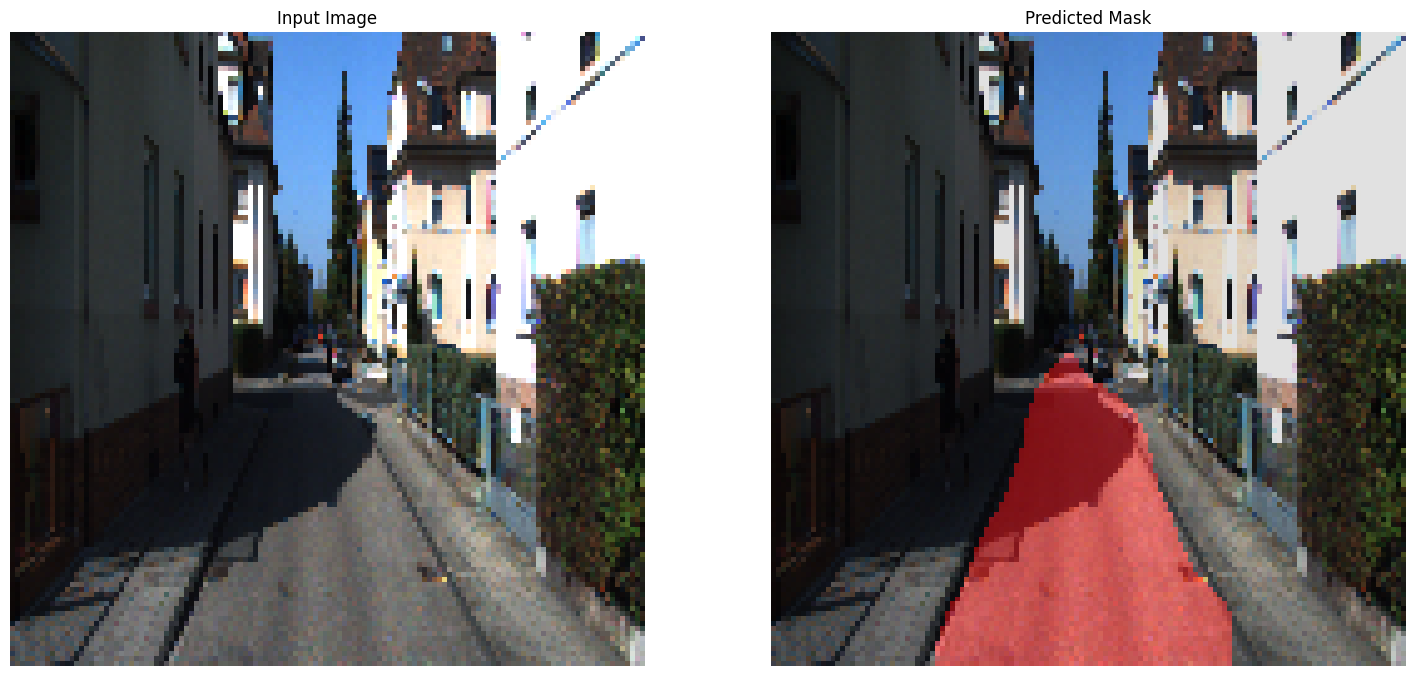

Processing image : 21
1/1 [==============================] - 0s 101ms/step


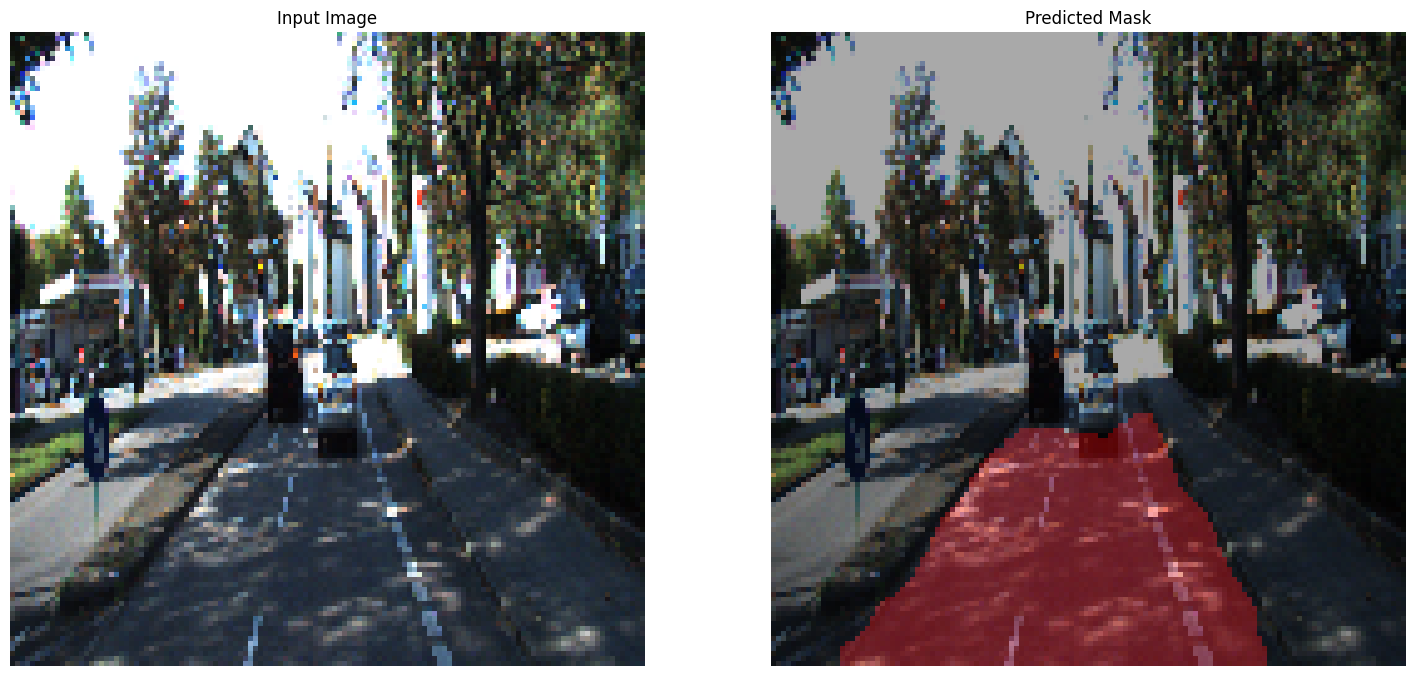

Processing image : 22
1/1 [==============================] - 0s 80ms/step


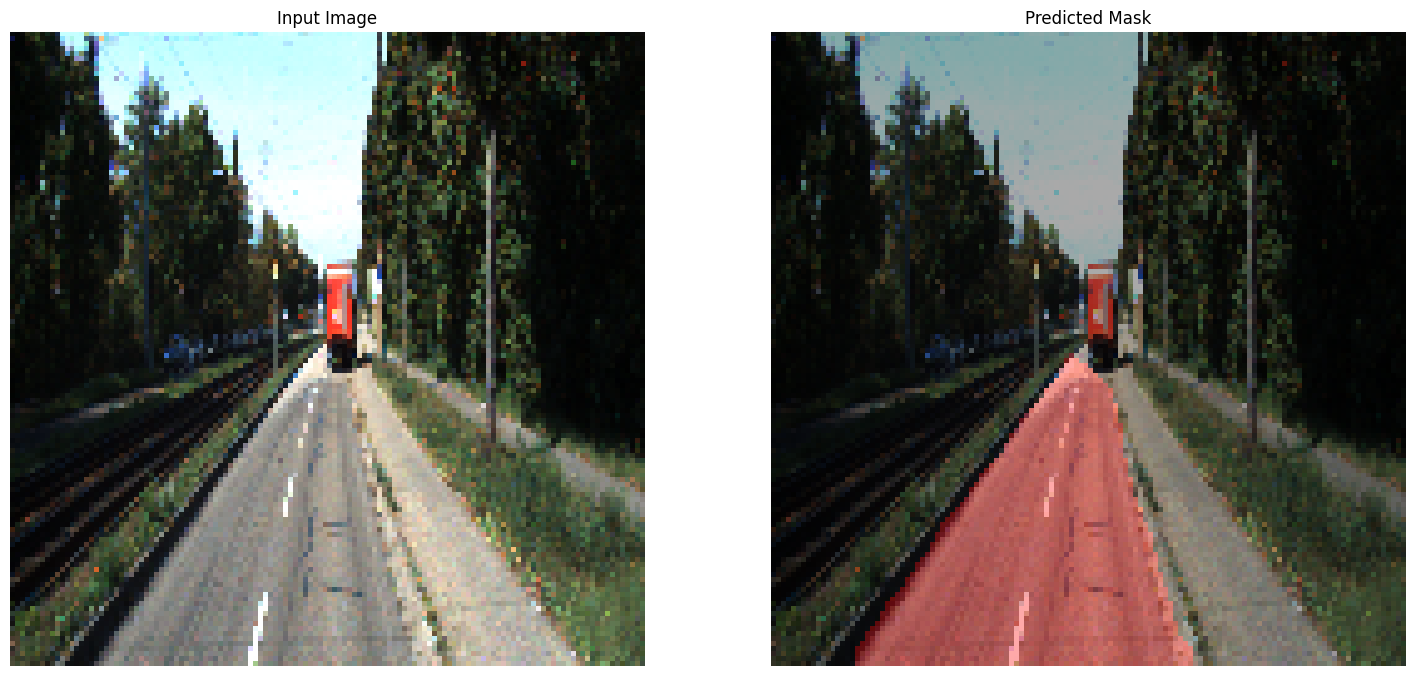

Processing image : 23
1/1 [==============================] - 0s 78ms/step


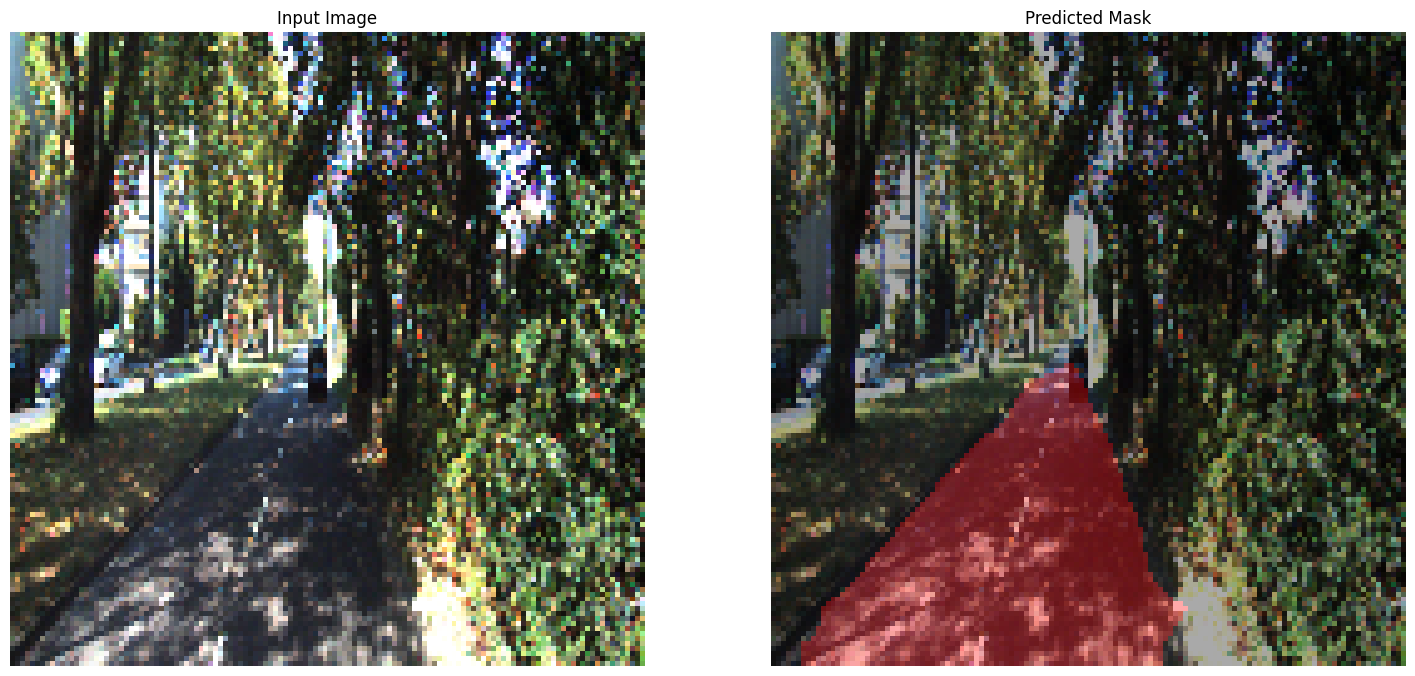

Processing image : 24
1/1 [==============================] - 0s 96ms/step


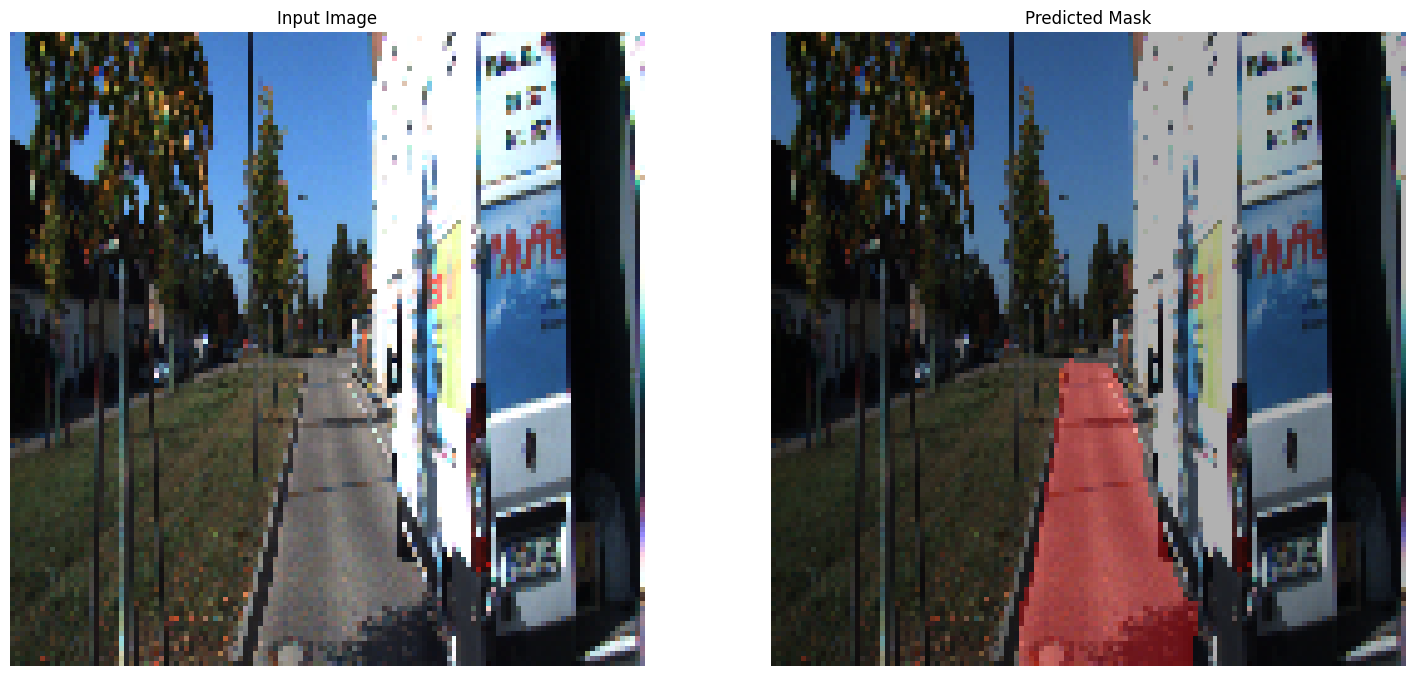

Processing image : 25
1/1 [==============================] - 0s 88ms/step


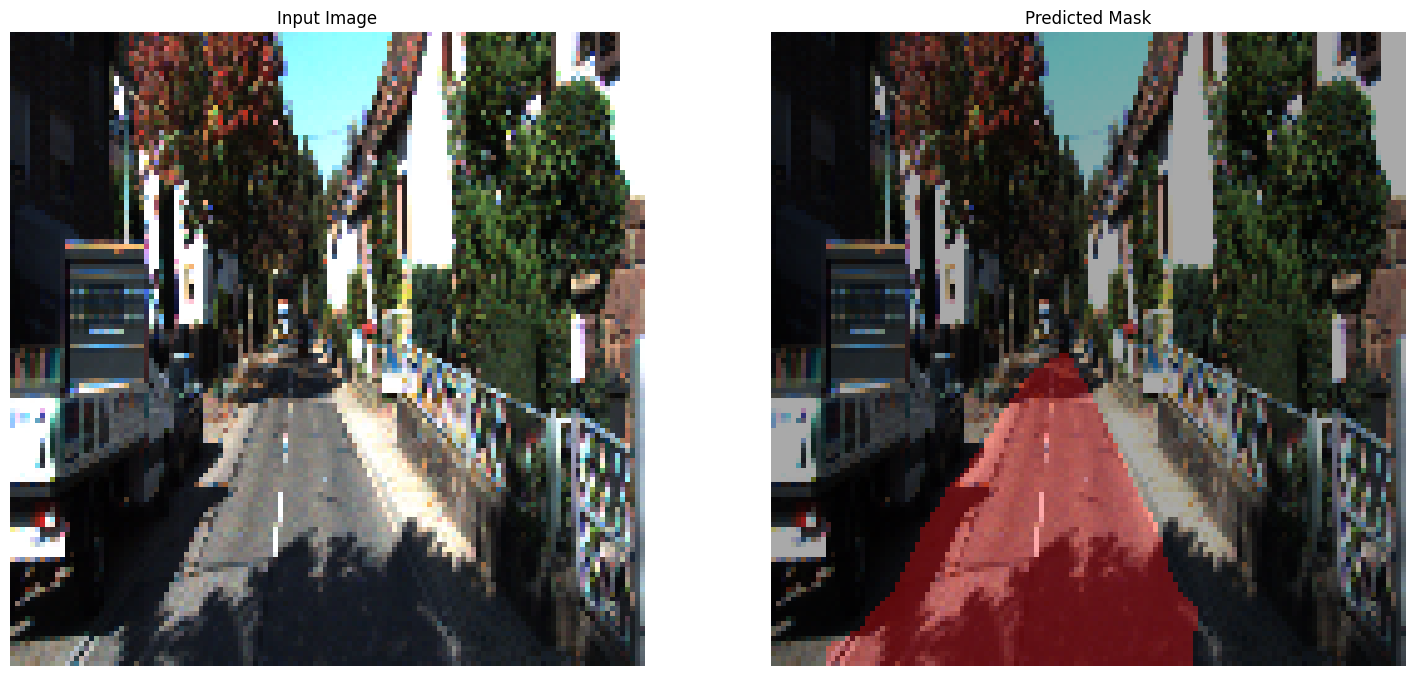

Processing image : 26
1/1 [==============================] - 0s 77ms/step


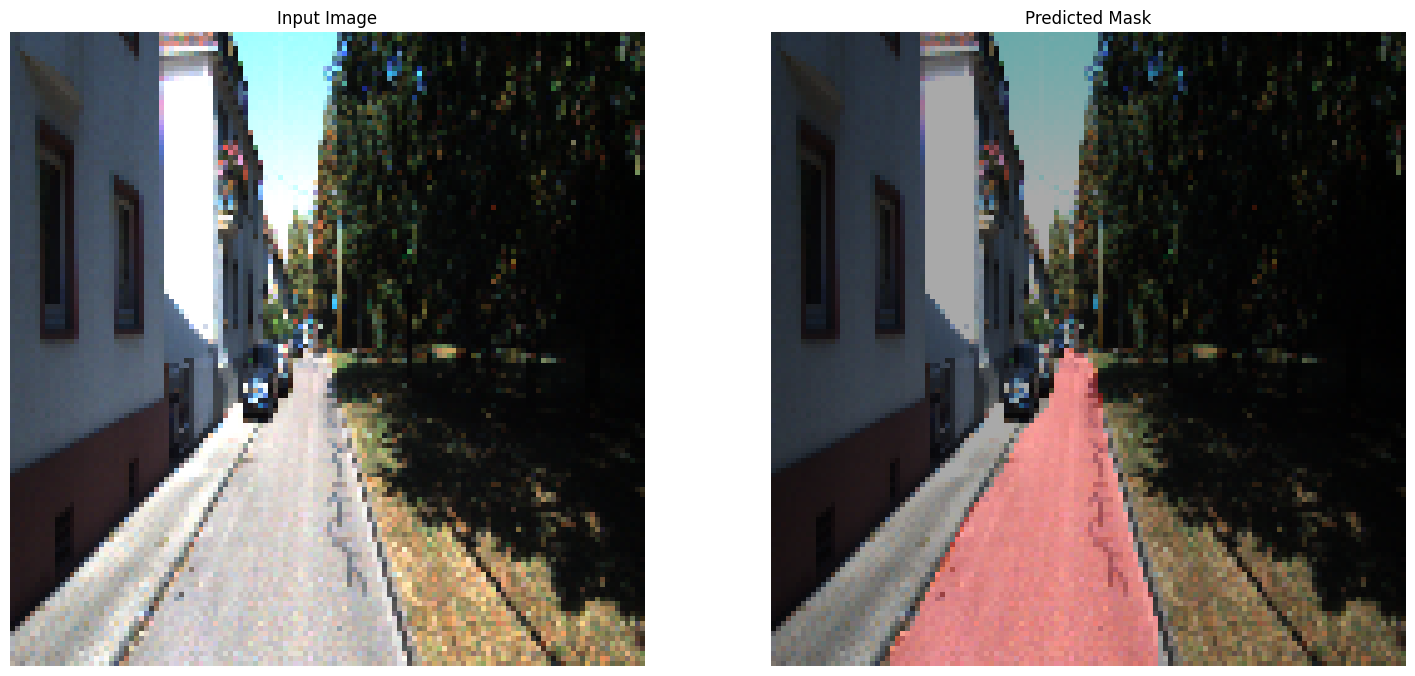

Processing image : 27
1/1 [==============================] - 0s 100ms/step


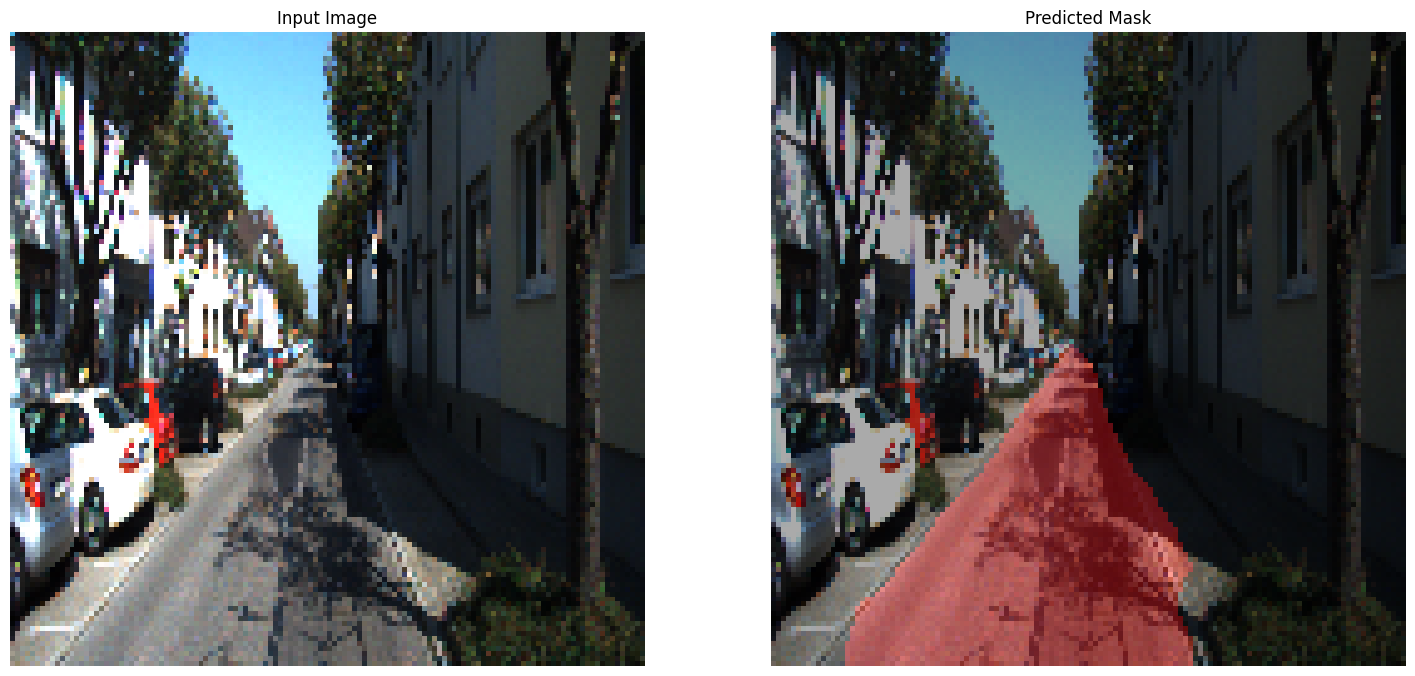

Processing image : 28
1/1 [==============================] - 0s 80ms/step


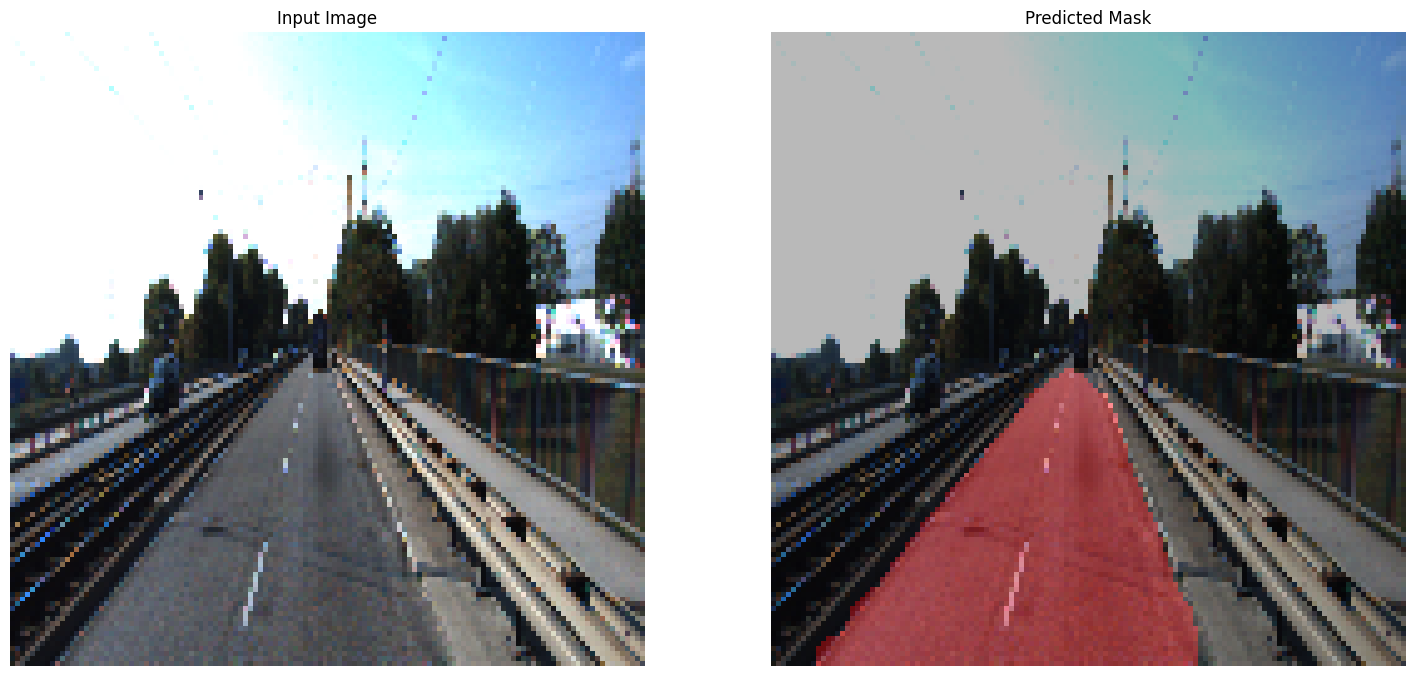

Processing image : 29
1/1 [==============================] - 0s 88ms/step


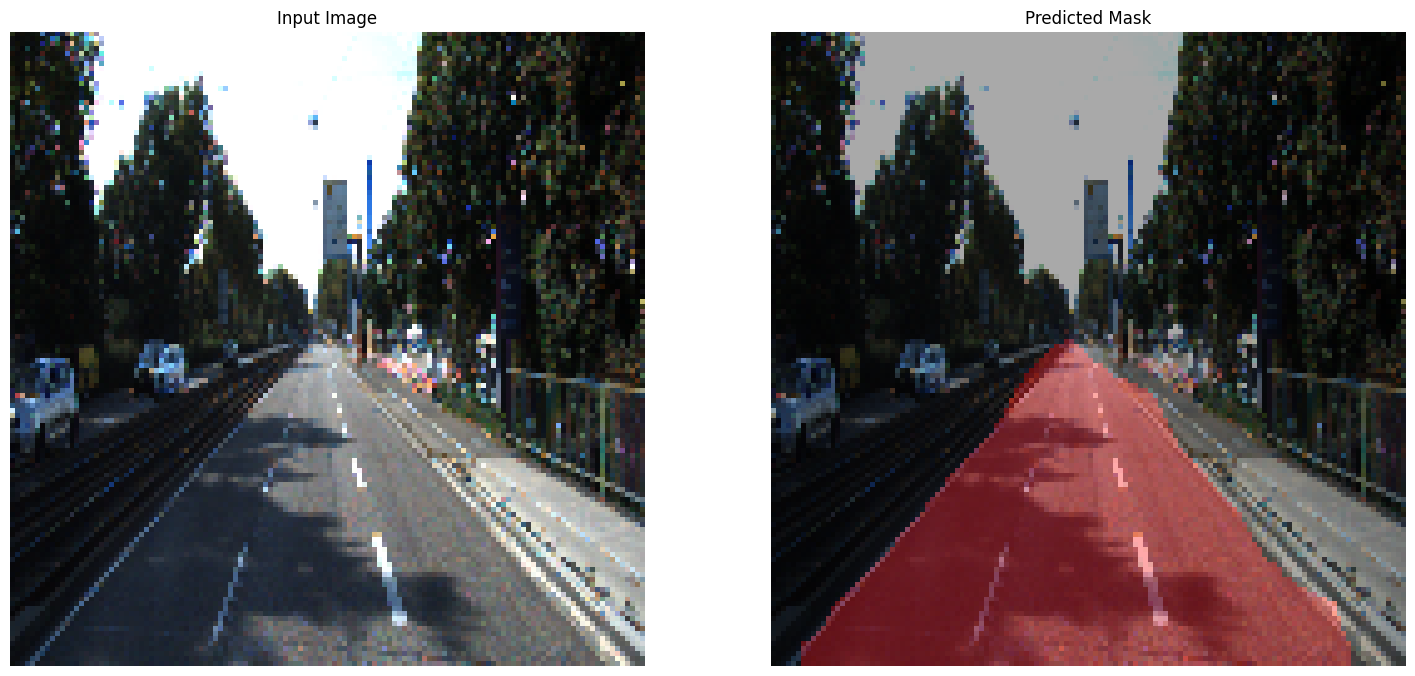

In [15]:
os.mkdir("outputs2")
save_predictions(dataset['test'])

## Testear video

In [29]:
# Function to view video
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [48]:
# Function to process an individual image
def process_image(image):
    # Preprocess image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    # Get the binary mask
    pred_mask = modelT.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])
    
    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)
    
    # Get the final image
    final_image = weighted_img(mask, image, α = 1, β = 0.5, γ = 0.1)
    final_image = cv2.resize(final_image, (1280, 720))

    return final_image

In [ ]:
# Make a new directory
os.mkdir("videos")

In [81]:
# Intenta cargar el video
project_video = "solidYellowLeft.mp4"
video_path = os.path.join(test_data_dir, project_video)
original_video = cv2.VideoCapture(video_path)

# Verifica si se abrió correctamente
if not original_video.isOpened():
    print(f"Error: no se pudo abrir el video {video_path}")
else:
    # Obtiene las dimensiones del video
    frame_width = int(original_video.get(3))
    frame_height = int(original_video.get(4))

    # Define el codec y el objeto VideoWriter
    fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    fps = 24
    output_path = os.path.join("videos", project_video)
    output = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Procesa el video
    while original_video.isOpened():
        ret, frame = original_video.read()

        if ret:
            # Escribe el frame procesado
            output.write(process_image(frame))
        else:
            break

    # Libera los recursos
    original_video.release()
    output.release()

1/1 [==============================] - 0s 224ms/step


C:\Users\PC\AppData\Local\Temp\ipykernel_52008\1347027196.py:26: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  output.write(process_image(frame))


1/1 [==============================] - 0s 282ms/step


## Testear imagenes

In [16]:
# Path a la carpeta de imágenes
input_folder = "image_test"
output_folder = "processed_images"

# Asegurarte de que la carpeta de salida existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterar sobre todas las imágenes en la carpeta
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Cargar la imagen
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        # Procesar la imagen
        processed_image = process_image(image)

        # Guardar la imagen procesada
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, processed_image)

NameError: name 'process_image' is not defined